In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
data_dir = ""
data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
import os

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [6]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

C:\Users\dared\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dared\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
train_loss_arr = []
train_accuracy_arr = []
valid_loss_arr = []
valid_accuracy_arr = []

def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "train":  
                train_loss_arr.append(epoch_loss)
                train_accuracy_arr.append(epoch_acc.cpu().numpy())
            if phase == "valid":  
                valid_loss_arr.append(epoch_loss)
                valid_accuracy_arr.append(epoch_acc.cpu().numpy())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_model(model, criterion, optimizer)

Epoch 1/10
----------
train Loss: 0.5432 Acc: 0.8139
valid Loss: 0.4608 Acc: 0.8414
Epoch 2/10
----------
train Loss: 0.4778 Acc: 0.8374
valid Loss: 0.4465 Acc: 0.8420
Epoch 3/10
----------
train Loss: 0.4120 Acc: 0.8606
valid Loss: 0.4164 Acc: 0.8605
Epoch 4/10
----------
train Loss: 0.3772 Acc: 0.8700
valid Loss: 0.3485 Acc: 0.8852
Epoch 5/10
----------
train Loss: 0.3336 Acc: 0.8868
valid Loss: 0.3987 Acc: 0.8649
Epoch 6/10
----------
train Loss: 0.3035 Acc: 0.8961
valid Loss: 0.3062 Acc: 0.8966
Epoch 7/10
----------
train Loss: 0.2670 Acc: 0.9114
valid Loss: 0.3012 Acc: 0.9018
Epoch 8/10
----------
train Loss: 0.2380 Acc: 0.9202
valid Loss: 0.2970 Acc: 0.9015
Epoch 9/10
----------
train Loss: 0.2180 Acc: 0.9266
valid Loss: 0.2560 Acc: 0.9173
Epoch 10/10
----------
train Loss: 0.1941 Acc: 0.9368
valid Loss: 0.2618 Acc: 0.9208


In [19]:
valid_loss_arr

[0.46079932993157224,
 0.44648053092271933,
 0.4164100806994583,
 0.3485101269610749,
 0.39870855282447515,
 0.30621521353953507,
 0.30124967088960486,
 0.297023339342807,
 0.25600133697358357,
 0.2618126167935132]

In [20]:
valid_accuracy_arr

[array(0.8413886),
 array(0.84198713),
 array(0.86054167),
 array(0.88523118),
 array(0.86488104),
 array(0.89660332),
 array(0.90184049),
 array(0.90154122),
 array(0.91725273),
 array(0.92084393)]

In [21]:
train_accuracy_arr

[array(0.81387341),
 array(0.83743423),
 array(0.86056948),
 array(0.87000929),
 array(0.88676106),
 array(0.89612349),
 array(0.91136645),
 array(0.92018725),
 array(0.9266481),
 array(0.93678428)]

In [22]:
train_loss_arr

[0.543181537604118,
 0.4777921431575977,
 0.4120392632056448,
 0.37719397671596805,
 0.333566040575449,
 0.3034819017084565,
 0.26696848822281993,
 0.23799637268106844,
 0.2180044768312995,
 0.19412487232207293]

In [23]:

from sklearn.metrics import confusion_matrix
def get_true_predicted_labels(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    return true_labels, predicted_labels
true_labels, predicted_labels = get_true_predicted_labels(model, dataloaders['valid'])


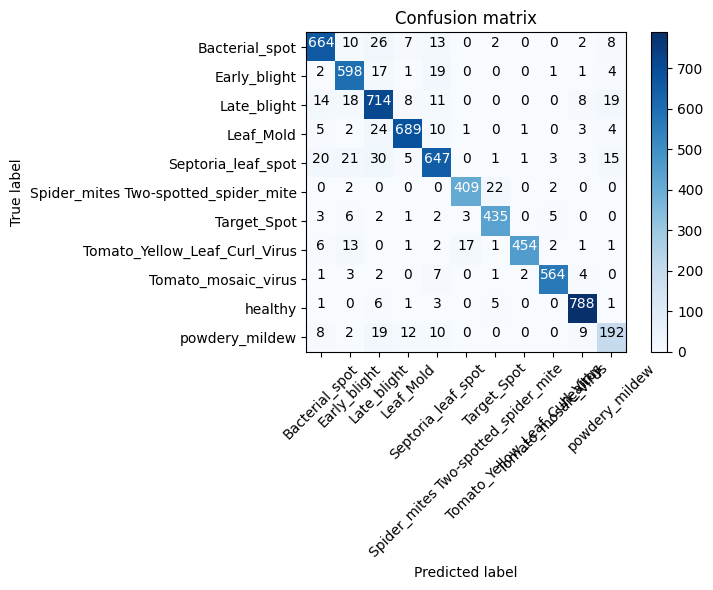

In [24]:
import numpy as np
import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
classes = image_datasets['valid'].classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add numerical values in each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()